In [1]:
import numpy as np
import gbm
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial
from astropy.io import fits
from functions import find_files

/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


In [ ]:
# reduce gbm data
# select the fermi id of the burst
fermi_id = "bn260111690"
energy_range = (8, 1000)  # in keV

erange_nai = (8, 900)
erange_bgo = (325, 35000)

bin_time = 0.064  # in seconds
bin_time_str = str(int(bin_time*1000))
bin_time_rb = 1.024  # in seconds for the background
rebf = int(bin_time_rb / bin_time)

# test if the data is already downloaded by checking if the folder exists
data_folder = f"./{fermi_id}"
if not os.path.exists(data_folder):
    # write a line of code from the terminal to download the data
    os.system(f"../take_GBM_burst_data.sh {fermi_id}")
if not os.path.exists(f"{fermi_id}/LC"):
    os.makedirs(f"{fermi_id}/LC")

chosen_detectors = ['n0','n6','n9','b0']


In [16]:
tte_files=[]
ttes=[]
for det in chosen_detectors:
    tte_files.append(find_files(f'{fermi_id}/glg_tte_{det}_{fermi_id}_v*.fit'))
    ttes.append(TTE.open(tte_files[-1]))
tte_files


det_time, det_counts, det_err_counts = [], [], []
phaiis = []
for det in ttes:
    phaii = det.to_phaii(bin_by_time, bin_time, time_ref = 0.0)
    phaiis.append(phaii)
    lc = phaii.to_lightcurve(energy_range = energy_range)
    counts = lc.counts 
    err_counts = np.sqrt(lc.counts+3/4)+1
    time = lc.centroids
    det_time.append(time)
    det_counts.append(counts)
    det_err_counts.append(err_counts)
#plt.ylim()

Using the latest version: bn260111690/glg_tte_n0_bn260111690_v00.fit
Using the latest version: bn260111690/glg_tte_n6_bn260111690_v00.fit
Using the latest version: bn260111690/glg_tte_n9_bn260111690_v00.fit
Using the latest version: bn260111690/glg_tte_b0_bn260111690_v00.fit


(-150.0, 150.0)

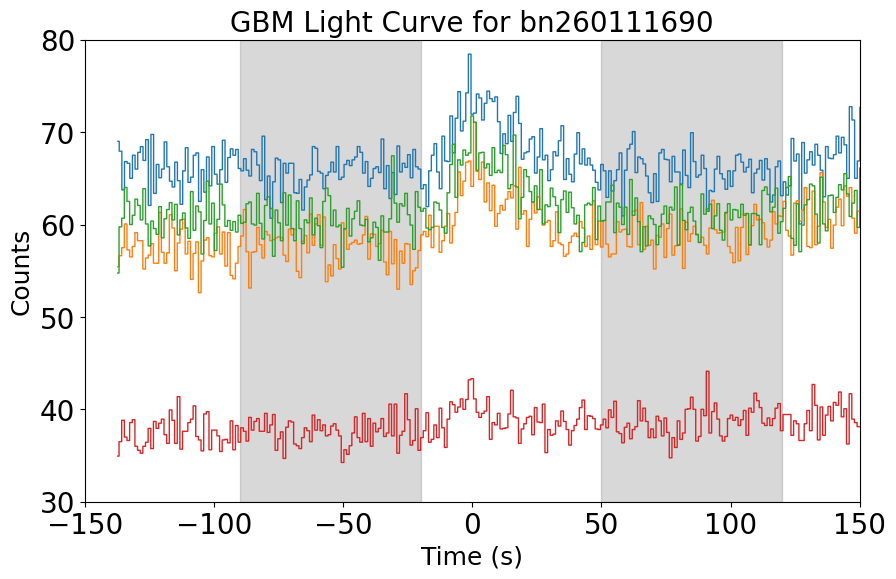

In [17]:
# choose the bkgd intervals
bkgd_intervals = [(-90.0, -20.0), (50.0, 120.0)]
t1, t2, t3, t4 = bkgd_intervals[0][0], bkgd_intervals[0][1], bkgd_intervals[1][0], bkgd_intervals[1][1]
plt.figure(figsize=(10,6))
# plot the light curve for all used detectors
#for i, det in enumerate(used_detectors):
#    plt.step(det_time[i], det_counts[i], where='mid', label=det)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# rebin the light curve to 1s
import sys
from turtle import bk

from numpy import average 
sys.path.append('/astrodata/romain/')
from sax_utils import rebin_lc_genau


#x_reb,y_reb,z_reb = rebin_lc_genau(det_time[2], det_counts[2], det_err_counts[2],4,ren=True)

# plot rebinned curve for each unit
for i in range(len(chosen_detectors)):
    x_reb,y_reb,z_reb = rebin_lc_genau(det_time[i], det_counts[i], det_err_counts[i],rebf,ren=True)
    plt.step(x_reb, y_reb, where='mid', label=f'rebinned lc {chosen_detectors[i]}', linewidth=1)
#plt.step(x_reb, y_reb, where='mid', label='rebinned lc', color='k', linewidth=2)
plt.axvspan(bkgd_intervals[0][0],bkgd_intervals[0][1], color='gray', alpha=0.3)
plt.axvspan(bkgd_intervals[1][0],bkgd_intervals[1][1], color='gray', alpha=0.3)
#plt.axvspan(t90_start, t90_start+t90, color='red', alpha=0.3)
#plt.xlim(t90_start-0.5*t90, t90_start+3*t90)
plt.xlim(bkgd_intervals[0][0]-10, bkgd_intervals[1][1]+10)
plt.title(f'GBM Light Curve for {fermi_id}', fontsize=20)
plt.ylim(30,80)
plt.xlim(-150,150)
#plt.legend(fontsize=14)


In [26]:
################################################################
# Find the intersection of all detectors' time
###############################################################
t11 = np.max([det_time[kk][0] for kk in range(len(det_time))])
t22 = np.min([det_time[kk][-1] for kk in range(len(det_time))])

for jj in range(len(det_time)):
    ind = np.where(  (det_time[jj]>t11) & (det_time[jj]<t22) )[0]
    det_time[jj] = det_time[jj][ind]
    det_counts[jj] = det_counts[jj][ind]
    det_err_counts[jj] = det_err_counts[jj][ind]

tstart = det_time[0]
tstop = tstart + bin_time

In [29]:
# Try several polynomial orders
poly_orders = [1, 2, 3]

for poly_order in poly_orders:
    # Fit background models
    backfitters = GbmDetectorCollection.from_list(
        [BackgroundFitter.from_phaii(phaii, Polynomial, bkgd_range) for phaii in phaiis],
        dets=chosen_detectors
    )
    backfitters.fit(order=poly_order)

    # Interpolate background bins
    bkgds = GbmDetectorCollection.from_list(
        backfitters.interpolate_bins(tstart,tstop),
        dets=chosen_detectors
    )

    # Compute background counts and errors
    bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
    bkgd_counts, bkgd_errors = zip(*[(bkgd_lc.counts, bkgd_lc.count_uncertainty) for bkgd_lc in bkgd_lcs])

    # Residual Analysis
    times = data_times[0]
    idx = np.where(
        ((times > bkgd_range[0][0]) & (times <= bkgd_range[0][1])) |
        ((times > bkgd_range[1][0]) & (times <= bkgd_range[1][1]))
    )[0]

    residuals = [(c[idx] - b[idx]) / e[idx] for c, b, e in zip(data_counts, bkgd_counts, data_errors)]
    means, devs, pvals = zip(
        *[(np.mean(residual), np.std(residual), scipy.stats.ks_1samp(residual, scipy.stats.norm.cdf)[1])
          for residual in residuals]
    )

    # Print results
    print(f'Poly Order: {poly_order}')
    print(f'Mean : {means[0]:5.2f} {means[1]:5.2f} {means[2]:5.2f}')
    print(f'Std  : {devs[0]:5.2f} {devs[1]:5.2f} {devs[2]:5.2f}')
    print(f'p-val: {pvals[0]:5.2f} {pvals[1]:5.2f} {pvals[2]:5.2f}')


# Choose the best polynomial order for each unit
chosen_poly_orders = [3,3,3,3]

# Fit background models
backfitters = GbmDetectorCollection.from_list(
    [BackgroundFitter.from_phaii(phaii, Polynomial, bkgd_range) for phaii in phaiis],
    dets=phaiis.detector()
)
[backfitter.fit(order=poly_order) for backfitter, poly_order in zip(backfitters, chosen_poly_orders)]

# Interpolate background bins
bkgds = GbmDetectorCollection.from_list(
    backfitters.interpolate_bins(tstart, tstop),
    dets=phaiis.detector()
)

# Compute background counts and errors
bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
bkgd_counts, bkgd_errors = zip(*[(bkgd_lc.counts, bkgd_lc.count_uncertainty) for bkgd_lc in bkgd_lcs])

# Residual Analysis
idx = np.where(
    ((times > bkgd_range[0][0]) & (times <= bkgd_range[0][1])) |
    ((times > bkgd_range[1][0]) & (times <= bkgd_range[1][1]))
)[0]

#residuals = [(c[idx] - b[idx]) / e[idx] for c, b, e in zip(det_time, bkgd_counts, data_errors)]
#means, devs, pvals = zip(
#    *[(np.mean(residual), np.std(residual), scipy.stats.ks_1samp(residual, scipy.stats.norm.cdf)[1])
#      for residual in residuals]
#)

# Print results
#print(f'Poly Order: {chosen_poly_orders[0]} {chosen_poly_orders[1]} {chosen_poly_orders[2]}')
#print(f'Mean : {means[0]:5.2f} {means[1]:5.2f} {means[2]:5.2f}')
#print(f'Std  : {devs[0]:5.2f} {devs[1]:5.2f} {devs[2]:5.2f}')
#print(f'p-val: {pvals[0]:5.2f} {pvals[1]:5.2f} {pvals[2]:5.2f}')

NameError: name 'data_times' is not defined

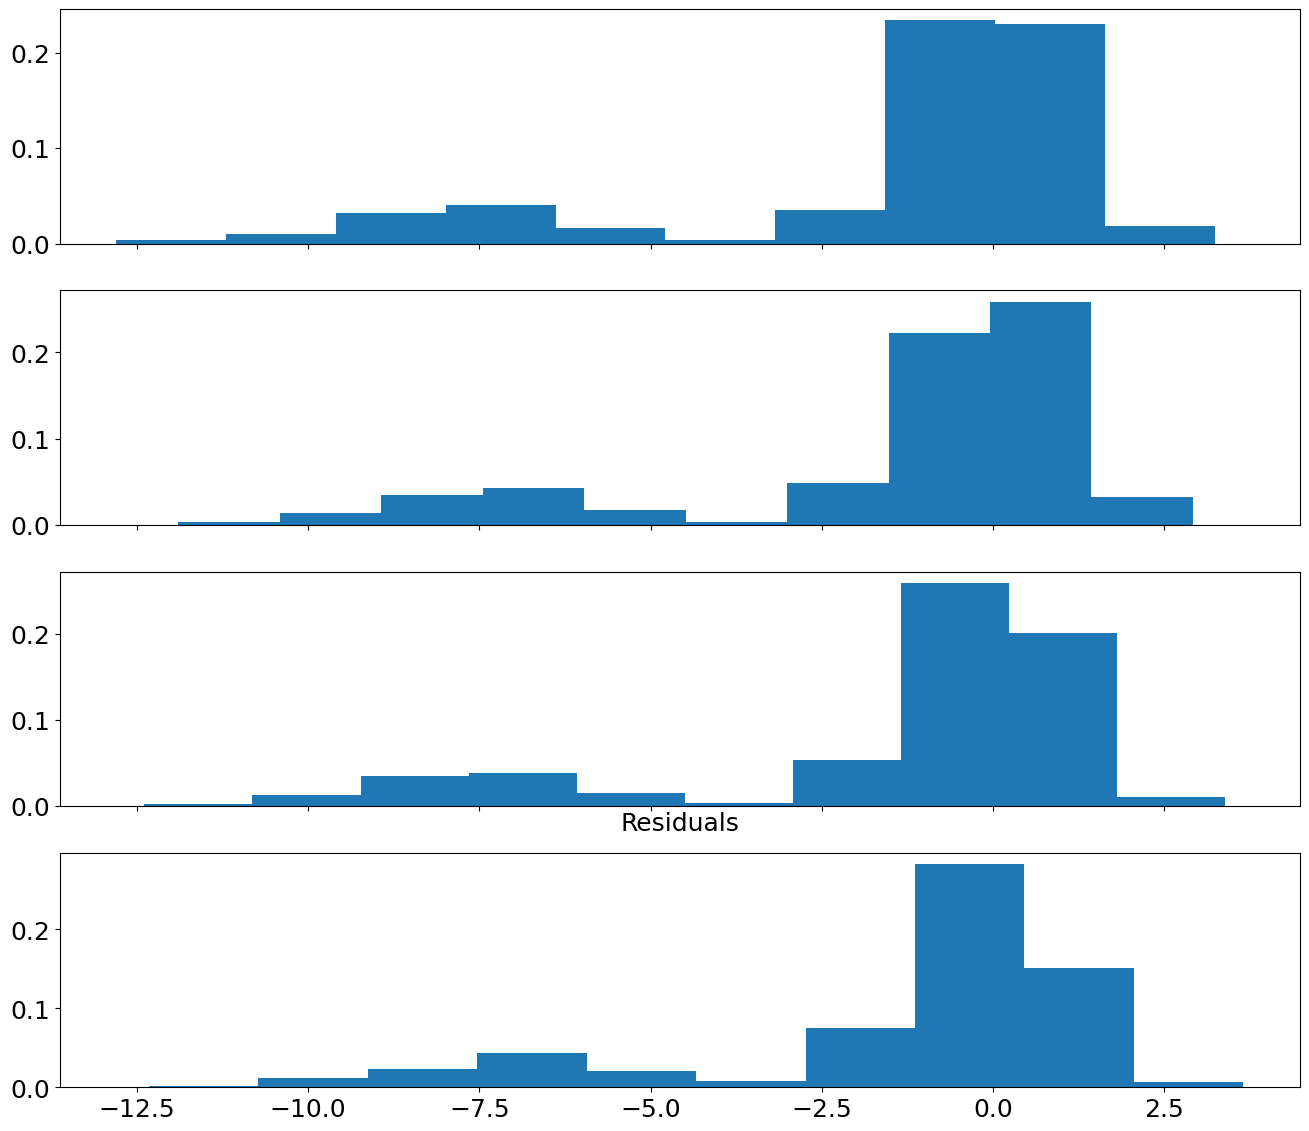

In [210]:
len(data_times[0]), len(data_times[1]),len(data_times[2]),len(data_counts[0]),len(data_counts[1]),len(data_counts[2]),len(bkgd_counts[0]),len(bkgd_counts[1]),len(bkgd_counts[2])

(9345, 9346, 9346, 9345, 9346, 9346, 9345, 9345, 9345)

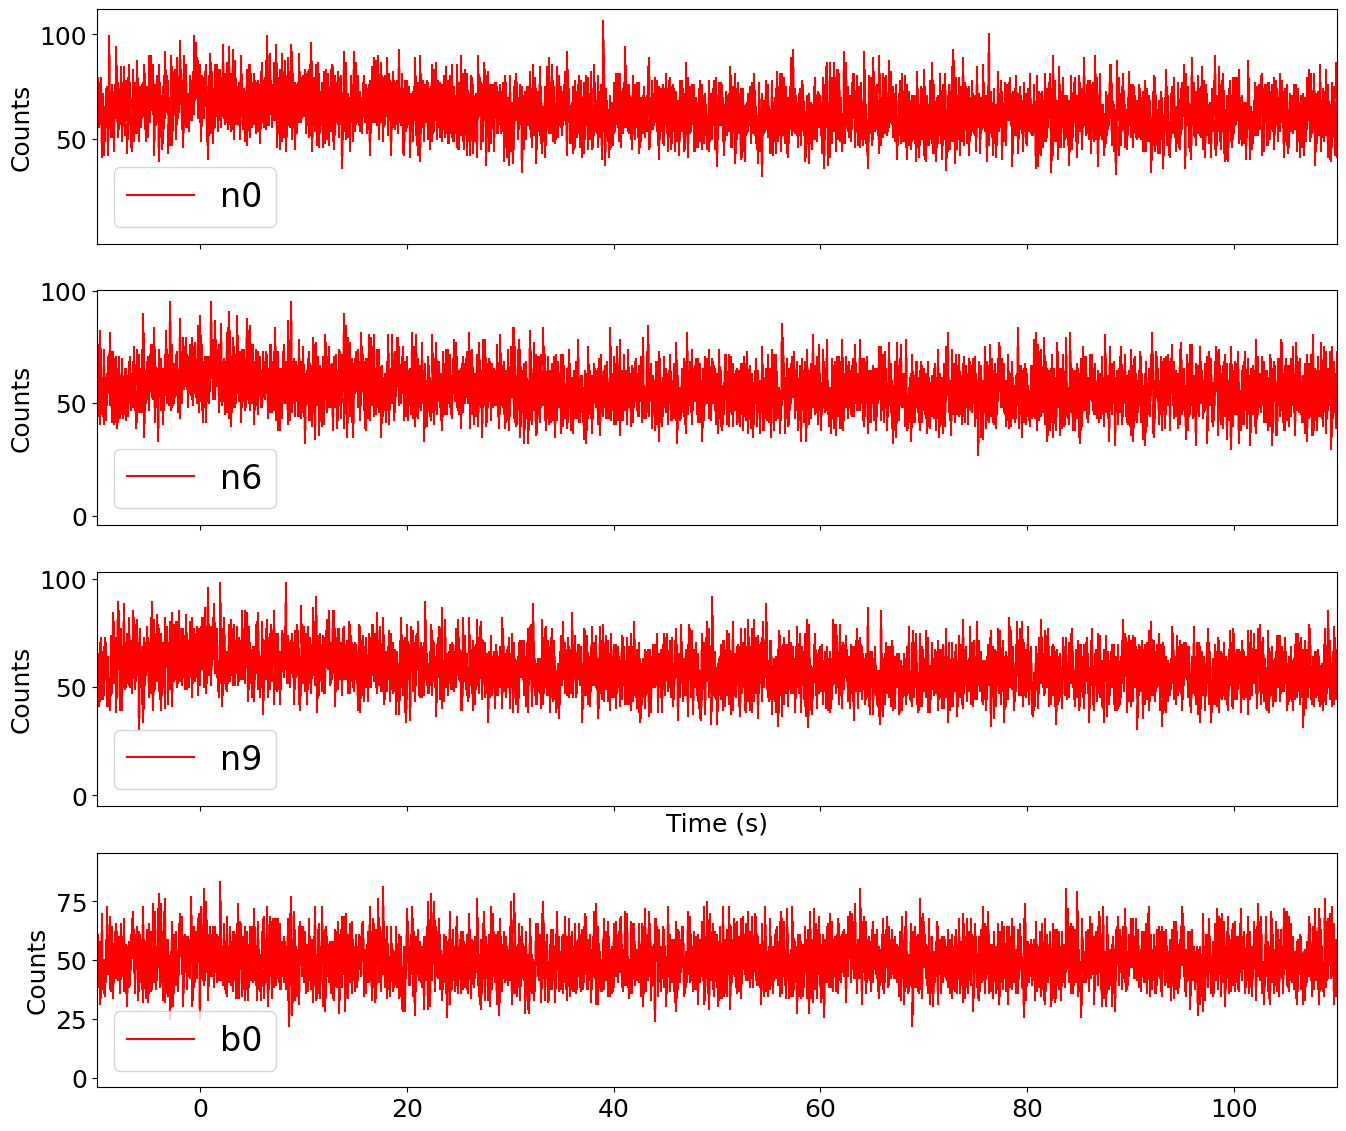

In [157]:
# the lightcurves
data_lcs = cspecs.to_lightcurve(nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})
# the energy-integrated background
bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
# the source time selection
src_lcs = cspecs.to_lightcurve(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# the count spectrum
data_specs = cspecs.to_spectrum(time_range=src_range)
# the time-integrated background
bkgd_specs = bkgds.integrate_time(*src_range)
# the energy selection
src_specs = cspecs.to_spectrum(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})


n0
n6
n9
b0


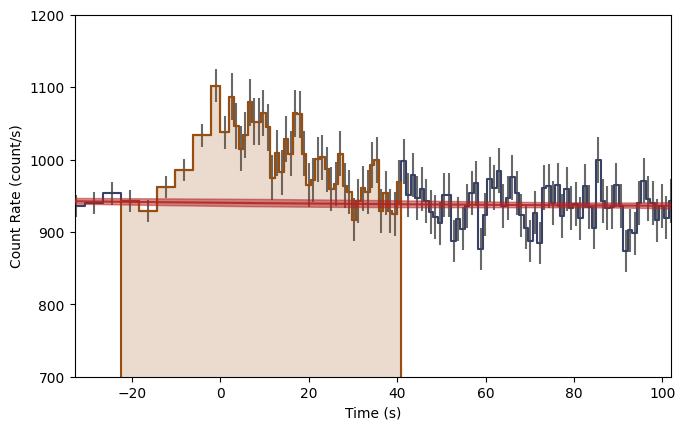

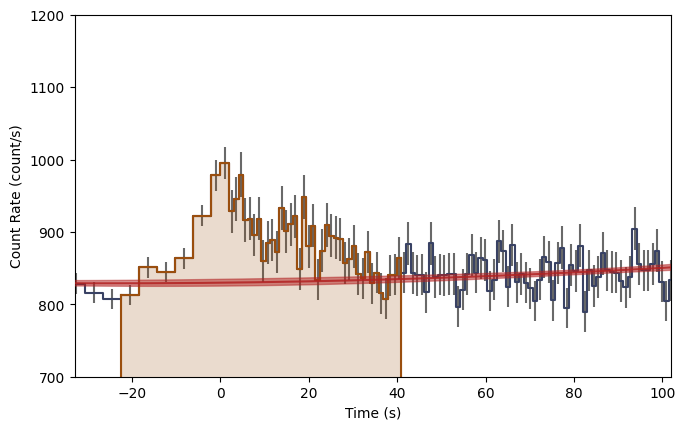

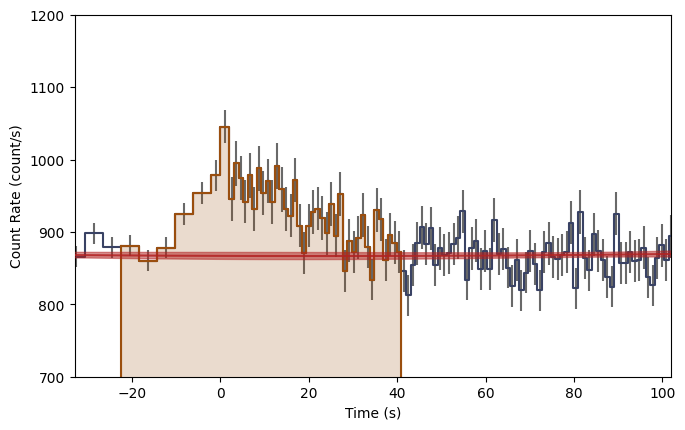

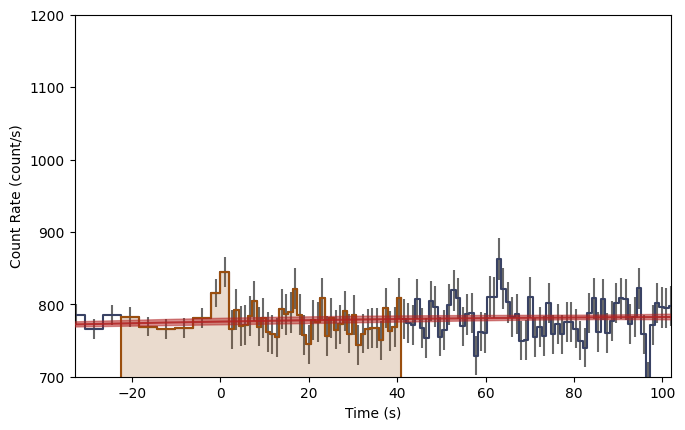

In [158]:
from gbm.plot import Lightcurve, Spectrum
from matplotlib import use

# Plot the lightcurves with the selections and background fit
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# zoom in
for lcplot in lcplots:
    print(used_detectors[lcplots.index(lcplot)])
    lcplot.xlim = view_range
    lcplot.ylim = (700,1200)

In [159]:
from gbm.data import RSP
phas = cspecs.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

rsps_list=[]
for i in range(len(used_detectors)):
    rsps_list.append(RSP.open(find_files(f'{fermi_id}/glg_cspec_{used_detectors[i]}_{fermi_id}_v*.rsp2')))

rsps = GbmDetectorCollection.from_list(rsps_list)

# and interpolate response files to get DRMs at center of the source window
rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

from gbm.spectra.fitting import SpectralFitterPgstat

# we initialize with our PHAs, backgrounds, and responses:
specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps.to_list(), method='TNC')

Using the latest version: bn260111690/glg_cspec_n0_bn260111690_v01.rsp2
Using the latest version: bn260111690/glg_cspec_n6_bn260111690_v01.rsp2
Using the latest version: bn260111690/glg_cspec_n9_bn260111690_v01.rsp2
Using the latest version: bn260111690/glg_cspec_b0_bn260111690_v01.rsp2


In [160]:

from gbm.spectra.functions import PowerLaw, Comptonized, Band

# instantiate a Band function
band = Band()
band.default_values[2] = -0.5
band.default_values[3] = -2.3
band.free[2] = True
band.free[3] = True

In [161]:
print('Band Fit:')
specfitter.fit(band, options={'maxiter': 1000})

# After the fit has converged, we can query the fitter for lots of info, including the parameters that
# satisfy the maximum likelihood as well as the parameter uncertainties resulting from -2(Delta)LogLike
print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

# Parameters
# Amplitude
A = specfitter.parameters[0]
ne_A = specfitter.asymmetric_errors(cl=0.9)[0][0]
pe_A = specfitter.asymmetric_errors(cl=0.9)[0][1]
print(f'A: {A:.4f} {ne_A:.4f} {pe_A:.4f}')

# Peak energy
Epeak = specfitter.parameters[1]
ne_Epeak = specfitter.asymmetric_errors(cl=0.9)[1][0]
pe_Epeak = specfitter.asymmetric_errors(cl=0.9)[1][1]
print(f'Epeak: {Epeak:.4f} {ne_Epeak:.4f} {pe_Epeak:.4f}')

# Alpha
alpha = specfitter.parameters[2]
ne_alpha = specfitter.asymmetric_errors(cl=0.9)[2][0]
pe_alpha = specfitter.asymmetric_errors(cl=0.9)[2][1]
print(f'Alpha: {alpha:.4f} {ne_alpha:.4f} {pe_alpha:.4f}')

# Beta
beta = specfitter.parameters[3]
ne_beta = specfitter.asymmetric_errors(cl=0.9)[3][0]
pe_beta = specfitter.asymmetric_errors(cl=0.9)[3][1]
print(f'Beta: {beta:.4f} {ne_beta:.4f} {pe_beta:.4f}')


if np.abs(beta) >= 3 or np.abs(ne_beta / beta) >= 0.3 or np.abs(pe_beta / beta) >= 0.3:
    print('Warning: The beta parameter is not well constrained.')
    print('--------------------------------------------------')
    print('Refitting Band function with beta fixed.')
    
    band.free[3] = False
    
    # Initialize and perform spectral fitting
    specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps.to_list(), method='TNC')
    specfitter.fit(band, options={'maxiter': 1000})

    print('Band Fit:')
    specfitter.fit(band, options={'maxiter': 1000})

    # After the fit has converged, we can query the fitter for lots of info, including the parameters that
    # satisfy the maximum likelihood as well as the parameter uncertainties resulting from -2(Delta)LogLike
    print(specfitter.message)
    print('Parameters: {}'.format(specfitter.parameters))
    print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))
    print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

    # Parameters
    # Amplitude
    A = specfitter.parameters[0]
    ne_A = specfitter.asymmetric_errors(cl=0.9)[0][0]
    pe_A = specfitter.asymmetric_errors(cl=0.9)[0][1]
    print(f'A: {A:.4f} {ne_A:.4f} {pe_A:.4f}')

    # Peak energy
    Epeak = specfitter.parameters[1]
    ne_Epeak = specfitter.asymmetric_errors(cl=0.9)[1][0]
    pe_Epeak = specfitter.asymmetric_errors(cl=0.9)[1][1]
    print(f'Epeak: {Epeak:.4f} {ne_Epeak:.4f} {pe_Epeak:.4f}')

    # Alpha
    alpha = specfitter.parameters[2]
    ne_alpha = specfitter.asymmetric_errors(cl=0.9)[2][0]
    pe_alpha = specfitter.asymmetric_errors(cl=0.9)[2][1]
    print(f'Alpha: {alpha:.4f} {ne_alpha:.4f} {pe_alpha:.4f}')

   

Band Fit:
Converged (|x_n-x_(n-1)| ~= 0)
Parameters: [ 1.05945826e-03  4.60789789e+03 -1.63551325e+00 -8.53221329e+00]


/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/functions.py:508: RuntimeWarning: overflow encountered in scalar multiply
  ebreak = (alpha - beta) * e0
/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/functions.py:513: RuntimeWarning: overflow encountered in scalar multiply
  logfxn[~idx] = np.log(A) + dindex * np.log(dindex * e0 / Epiv) - \
/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/functions.py:507: RuntimeWarning: overflow encountered in scalar divide
  e0 = Epeak / (2.0 + alpha)
/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/fitting.py:386: RuntimeWarning: overflow encountered in scalar multiply
  maxval = 2.0 * param


90% Asymm. Errors:
 [[1.20787910e-04 1.21322627e-04]
 [4.08476345e+03            inf]
 [9.64112282e-02 1.08145595e-01]
 [1.46778671e+00 6.53211329e+00]]
Pgstat/DoF: 658.2458684133927/472
A: 0.0011 0.0001 0.0001
Epeak: 4607.8979 4084.7635 inf
Alpha: -1.6355 0.0964 0.1081
Beta: -8.5322 1.4678 6.5321
--------------------------------------------------
Refitting Band function with beta fixed.
Band Fit:
Converged (|x_n-x_(n-1)| ~= 0)
Parameters: [ 1.10239388e-03  1.34336342e+03 -1.61028749e+00]
90% Asymm. Errors:
 [[1.12770807e-04 1.13249594e-04]
 [9.05655303e+02            inf]
 [8.94010065e-02 1.02060914e-01]]
Pgstat/DoF: 658.6702722059708/473
A: 0.0011 0.0001 0.0001
Epeak: 1343.3634 905.6553 inf
Alpha: -1.6103 0.0894 0.1021


In [162]:
np.diag(specfitter.covariance)

array([-9.27118092e-12, -2.85376460e+03,  1.45115746e-03])

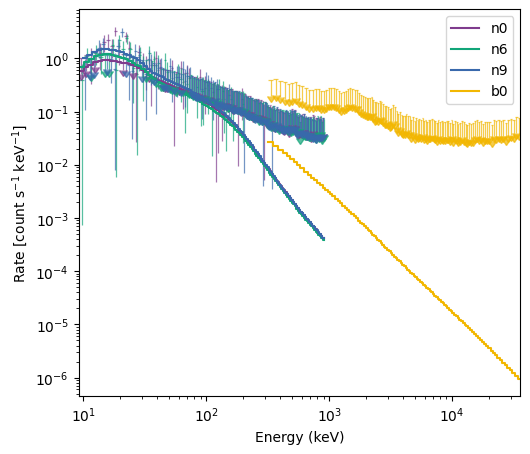

In [163]:
from gbm.plot import ModelFit

# initialize with your spectral fitter once the fit is done
modelplot = ModelFit(fitter=specfitter,resid=False)

/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/fitting.py:600: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


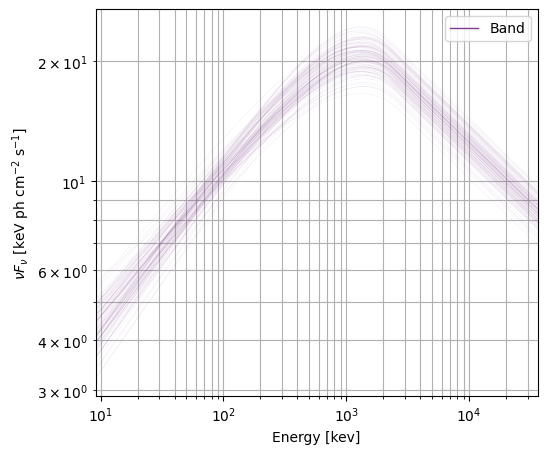

In [164]:
modelplot = ModelFit(fitter=specfitter, view='nufnu')
modelplot.ax.grid(which='both')

In [165]:
A,A_low,A_high = specfitter.parameters[0],specfitter.asymmetric_errors(cl=0.9)[0,0],specfitter.asymmetric_errors(cl=0.9)[0,1]
Ep,Ep_low,Ep_high = specfitter.parameters[1],specfitter.asymmetric_errors(cl=0.9)[1,0],specfitter.asymmetric_errors(cl=0.9)[1,1]
alpha,alpha_low,alpha_high = specfitter.parameters[2],specfitter.asymmetric_errors(cl=0.9)[2,0],specfitter.asymmetric_errors(cl=0.9)[2,1]
print(f"A = {A:.3e} (+{A_high:.3e}, -{A_low:.3e}) ph/cm^2/s/keV")
print(f"Ep = {Ep:.2f} (+{Ep_high:.2f}, -{Ep_low:.2f}) keV")
print(f"alpha = {alpha:.2f} (+{alpha_high:.2f}, -{alpha_low:.2f})")


/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/functions.py:507: RuntimeWarning: overflow encountered in scalar divide
  e0 = Epeak / (2.0 + alpha)
/home/romain/miniconda3/envs/gbm/lib/python3.8/site-packages/gbm/spectra/fitting.py:386: RuntimeWarning: overflow encountered in scalar multiply
  maxval = 2.0 * param


A = 1.102e-03 (+1.132e-04, -1.128e-04) ph/cm^2/s/keV
Ep = 1343.36 (+inf, -905.66) keV
alpha = -1.61 (+0.10, -0.09)


In [169]:
# flux over 10-1000 keV
photon_flux = band.integrate(specfitter.parameters, (10.0, 1000.0)) # photons/s/cm^2
energy_flux = band.integrate(specfitter.parameters, (10.0, 1000.0), energy=True) # erg/s/cm^2
photon_flux, energy_flux
fluence = energy_flux * (src_range[1]-src_range[0])  # erg/cm^2

print(f"{fluence:.2e} erg/cm^2")

# compute lower and upper bound by taking lower and upper values of the peak energy
#params_low = specfitter.parameters - 
#params_low[1] = 77 -30
#energy_flux_low = band.integrate(params_low, (10.0, 1000.0), energy=True)
#fluence_low = energy_flux_low * (src_range[1]-src_range[0])  # erg/cm^2

#params_high = specfitter.parameters
#params_high[1] = 77 +1000
#energy_flux_high = band.integrate(params_high, (10.0, 1000.0), energy=True)
#fluence_high = energy_flux_high * (src_range[1]-src_range[0])  # erg/cm^2

# error 
#fluence_err_low = fluence - fluence_low
#fluence_err_high = fluence_high - fluence
#print(fluence_err_low, fluence_err_high)
# format the results with errors]
#print(f"{fluence:.2e} (+{fluence_err_high:.3e}, -{fluence_err_low:.2e}) erg/cm^2")

5.06e-06 erg/cm^2


In [166]:
# simulate a multidimensional Gaussian
from scipy.stats import multivariate_normal
mean = specfitter.parameters
cov = specfitter.covariance
samples = multivariate_normal.rvs(mean=mean, cov=np.abs(cov), size=10000)
print(samples)
fluences = []
for sample in samples:
    fluence = band.integrate(sample, (10.0, 1000.0), energy=True)*(src_range[1]-src_range[0])
    fluences.append(fluence)


[[ 1.05824653e-03  1.30654592e+03 -1.65525786e+00]
 [ 1.13773944e-03  1.36924398e+03 -1.69232247e+00]
 [ 1.07027773e-03  1.27840517e+03 -1.61771681e+00]
 ...
 [ 1.10594440e-03  1.23432365e+03 -1.62500734e+00]
 [ 1.05892174e-03  1.31769877e+03 -1.61667564e+00]
 [ 1.10537965e-03  1.37202556e+03 -1.57570881e+00]]


5.07e-06 (+5.207e-07, -5.13e-07) erg/cm^2


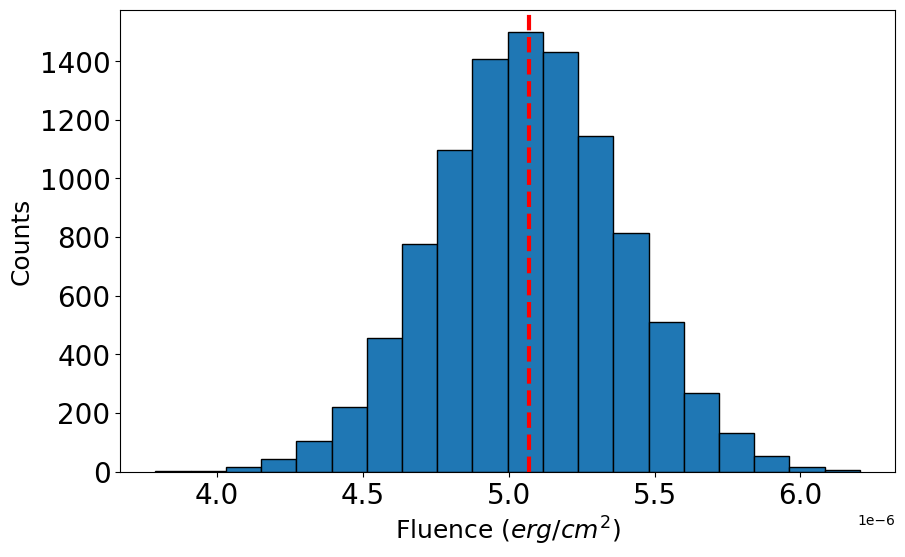

In [148]:
plt.figure(figsize=(10,6))
plt.hist(fluences, bins=20, edgecolor='black')
plt.axvline(np.mean(fluences), color='r', linestyle='dashed', linewidth=3)
plt.xlabel(r'Fluence $(erg/cm^2)$', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fl_low,fl_mean,fl_high=np.percentile(fluences,[5,50,95])
print(f"{fl_mean:.2e} (+{fl_high-fl_mean:.3e}, -{fl_mean-fl_low:.2e}) erg/cm^2")